#### 1. import data

In [1]:
import hail as hl
rett = hl.import_vcf('../../inputs/191102-rett-wgs.vep_tx_191206.vcf.bgz', reference_genome='GRCh38')

Initializing Spark and Hail with default parameters...
Running on Apache Spark version 2.4.1
SparkUI available at http://192.168.0.5:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.28-61941242c15d
LOGGING: writing to /Users/lizzychoi/rett_syndrome/scripts/rett_syndrome/hail-20200110-1007-0.2.28-61941242c15d.log


In [66]:
#print(rett.count())

---

#### 2. variant filtering
> - `filter == PASS`인 variant만 남기기
> - multi allelic 확인 및 제외
> - gnomAD AC==0인(한번도 발견된 적 없는 variant)만 남기기
> - chrM, chrX, chrY 제외
> - LCR(low complexity region) 제외

#### (1) `filter == PASS`인 variant만 남기기 

In [2]:
rett = rett.filter_rows(hl.len(rett.filters) == 0)

In [5]:
#print(rett.count())

#### (2) multi allelic 확인 및 제외

In [6]:
import gzip

multi_allelic = 0

with gzip.open('../../inputs/191102-rett-wgs.vep_tx_191206.vcf.bgz', 'rt') as f:
    for l in f:
        if l[0:1] != '#':
            if ',' in l.strip('\n').split('\t')[4]:
                multi_allelic += 1

print(multi_allelic)

1111205


In [3]:
## Split multiallelic variants
rett = hl.split_multi(rett)

## Drop multiallelic variants
rett = rett.filter_rows(rett.was_split == False)

#rett.count()

#### (3) gnomAD AC==0인(한번도 발견된 적 없는 variant)만 남기기


##### (CSQ_gnomADg_AF활용)
- `gnomADg_AF`의 'g'는 genome(cf. gnomAD_AF는 ExAC)
- `gnomADg_AF` 정보가 없는 variant만 남기기(즉,  ["", "", ""] 경우만 남김) => **330122**
 - ["0","0","0","0"]인 경우도 포함 => **332777**

In [8]:
import gzip
with gzip.open('../../inputs/191102-rett-wgs.vep_tx_191206.vcf.bgz', 'rt') as f:
    for l in f:
        if 'ID=CSQ' in l:
            temp = l.strip('\n').split('|')
            break

temp[0] = 'Allele';temp[70] = 'gnomADg_AF'

#print(temp)
print(temp.index('gnomADg_AF'))

70


In [45]:
#temp

['Allele',
 'Consequence',
 'IMPACT',
 'SYMBOL',
 'Gene',
 'Feature_type',
 'Feature',
 'BIOTYPE',
 'EXON',
 'INTRON',
 'HGVSc',
 'HGVSp',
 'cDNA_position',
 'CDS_position',
 'Protein_position',
 'Amino_acids',
 'Codons',
 'Existing_variation',
 'DISTANCE',
 'STRAND',
 'FLAGS',
 'VARIANT_CLASS',
 'SYMBOL_SOURCE',
 'HGNC_ID',
 'CANONICAL',
 'MANE',
 'TSL',
 'APPRIS',
 'CCDS',
 'ENSP',
 'SWISSPROT',
 'TREMBL',
 'UNIPARC',
 'SOURCE',
 'GENE_PHENO',
 'NEAREST',
 'SIFT',
 'PolyPhen',
 'DOMAINS',
 'miRNA',
 'HGVS_OFFSET',
 'AF',
 'AFR_AF',
 'AMR_AF',
 'EAS_AF',
 'EUR_AF',
 'SAS_AF',
 'AA_AF',
 'EA_AF',
 'gnomAD_AF',
 'gnomAD_AFR_AF',
 'gnomAD_AMR_AF',
 'gnomAD_ASJ_AF',
 'gnomAD_EAS_AF',
 'gnomAD_FIN_AF',
 'gnomAD_NFE_AF',
 'gnomAD_OTH_AF',
 'gnomAD_SAS_AF',
 'MAX_AF',
 'MAX_AF_POPS',
 'CLIN_SIG',
 'SOMATIC',
 'PHENO',
 'PUBMED',
 'MOTIF_NAME',
 'MOTIF_POS',
 'HIGH_INF_POS',
 'MOTIF_SCORE_CHANGE',
 'MPC',
 'gnomADg',
 'gnomADg_AF']

In [4]:
rett = rett.annotate_rows(csq = rett.info.CSQ)
rett = rett.transmute_rows(csq_gnomADg_AF = rett.csq.map(lambda x: x.split('\|')[70]))

---

In [10]:
## transcipt이 여러개여도, 같은 variant에 한해서는 gnomADg_AF값은 같다.
#rett.filter_rows(hl.len(hl.set(rett.csq_gnomADg_AF))!=1).count_rows()

In [11]:
l = hl.array(['0',''])
rett = rett.filter_rows(rett.csq_gnomADg_AF.all(lambda x: l.contains(x)))

In [83]:
#rett.count_rows()

332777

#### (4)chrM, chrX, chrY 제외

In [12]:
rett = rett.filter_rows(rett.locus.in_autosome())

#### (5) lcr(low complexity region)제외

In [13]:
lcr_bed = hl.import_bed('../../../Resources/lcr/LCR-hs38.bed', reference_genome = 'GRCh38')

2019-12-24 11:15:12 Hail: INFO: Reading table with no type imputation
  Loading column 'f0' as type 'str' (user-specified)
  Loading column 'f1' as type 'int32' (user-specified)
  Loading column 'f2' as type 'int32' (user-specified)



In [14]:
lcr_bed.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'interval': interval<locus<GRCh38>> 
----------------------------------------
Key: ['interval']
----------------------------------------


In [15]:
rett = rett.filter_rows(~hl.is_defined(lcr_bed[rett.locus]))

In [76]:
#rett.count_rows()

---

#### 3. rare variants만 남기기 (rare variants : AC==2인 변이들로 가정) + hom 제거하고 het만 

In [17]:
rett_rare = rett.filter_rows(rett.info.AC[0] == 2)
#print(rett_rare.count_rows())

In [78]:
#위의 cell과 같은 결과

#rett = hl.variant_qc(rett)
#rett_rare_s = rett.filter_rows((rett.variant_qc.AC[0]==2)|(rett.variant_qc.AC[1]==2))
#print(rett_rare.count_rows())

In [18]:
## drop vairants(homozygous)
rett_rare = hl.variant_qc(rett_rare)
rett_rare_het = rett_rare.filter_rows(rett_rare.variant_qc.n_het==2)

#print(rett_rare_het.count_rows())

In [80]:
rett_rare_het.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str
----------------------------------------
Row fields:
    'locus': locus<GRCh38>
    'alleles': array<str>
    'rsid': str
    'qual': float64
    'filters': set<str>
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        DB: bool, 
        DP: int32, 
        DS: bool, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        NEGATIVE_TRAIN_SITE: bool, 
        POSITIVE_TRAIN_SITE: bool, 
        QD: float64, 
        RAW_MQandDP: array<int32>, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        culprit: str, 
        CSQ: array<str>, 
        gnomADg: array<str>, 
 

---

#### 5. Positive, Negative set 만들기
- Index : **variant, Role, Fam**
- features 
    - **va_QUAL, va_AN, va_BaseQRankSum,va_DP,va_ExcessHet, va_FS, va_InbreedingCoeff, va_MQ,va_MQRankSum, va_QD, va_ReadPosRankSum, va_SOR, va_VQSLOD, va_GQM**
    - **g_GQ, g_AD**(--> `rocube.py`에서 **g_DP**, **g_AB**계산 된다)
- label : **TP** 

In [19]:
MT_PN = rett_rare_het.filter_entries(rett_rare_het.GT.is_het())
Table_PN = MT_PN.entries()
Table_PN = Table_PN.annotate(va_AN = Table_PN.info.AN,
                             va_BaseQRankSum = Table_PN.info.BaseQRankSum,
                             va_DP = Table_PN.info.DP,
                             va_ExcessHet = Table_PN.info.ExcessHet,
                             va_FS = Table_PN.info.FS,
                             va_InbreedingCoeff = Table_PN.info.InbreedingCoeff,
                             va_MQ = Table_PN.info.MQ,
                             va_MQRankSum = Table_PN.info.MQRankSum,
                             va_QD = Table_PN.info.QD,
                             va_ReadPosRankSum = Table_PN.info.ReadPosRankSum,
                             va_SOR = Table_PN.info.SOR,
                             va_VQSLOD = Table_PN.info.VQSLOD,
                             va_GQM =Table_PN.variant_qc.gq_stats.mean)

2019-12-24 11:16:19 Hail: WARN: entries(): Resulting entries table is sorted by '(row_key, col_key)'.
    To preserve row-major matrix table order, first unkey columns with 'key_cols_by()'


In [20]:
#### Index and Features
## variant
Table_PN_i = Table_PN.annotate(v1 = hl.tuple([Table_PN.locus.contig.replace("chr", ""),hl.str(Table_PN.locus.position)]),
                               v2 = hl.tuple([Table_PN.alleles[0],Table_PN.alleles[1]]))
Table_PN_i = Table_PN_i.transmute(variant = hl.delimit(hl.array([Table_PN_i.v1[0], 
                                                              Table_PN_i.v1[1], 
                                                              Table_PN_i.v2[0], 
                                                              Table_PN_i.v2[1]]), ":"))

## Role, Fam, TP
Table_PN_i = Table_PN_i.annotate(Role = Table_PN_i.s.split('_')[1],
                                 Fam = Table_PN_i.s.split('_')[0],
                                 TP = 0)

## Role(category 1,2,3 --> p, mo, fa)
## qual, GQ, AD
Table_PN_i = Table_PN_i.transmute(Role = hl.cond(Table_PN_i.Role=='1', 'p', hl.cond(Table_PN_i.Role=='2', 'mo','fa')),
                                 va_QUAL = Table_PN_i.qual,
                                 g_GQ = Table_PN_i.GQ,
                                 g_AD = Table_PN_i.AD)

## Updating fields (select columns)
Table_PN_complete = Table_PN_i.select(Table_PN_i.variant, Table_PN_i.Role, Table_PN_i.Fam, Table_PN_i.TP,
                                      Table_PN_i.va_QUAL,Table_PN_i.va_AN,Table_PN_i.va_BaseQRankSum,
                                      Table_PN_i.va_DP,Table_PN_i.va_ExcessHet,Table_PN_i.va_FS,
                                      Table_PN_i.va_InbreedingCoeff,
                                      Table_PN_i.va_MQ,Table_PN_i.va_MQRankSum,
                                      Table_PN_i.va_QD,Table_PN_i.va_ReadPosRankSum,
                                      Table_PN_i.va_SOR,Table_PN_i.va_VQSLOD,Table_PN_i.va_GQM,
                                      Table_PN_i.g_GQ,Table_PN_i.g_AD)

## key drop --> key : variant
Table_PN_complete = Table_PN_complete.key_by(Table_PN_complete.variant)

## Updating fields (drop columns)
Table_PN_complete = Table_PN_complete.drop(Table_PN_complete.locus, Table_PN_complete.alleles, Table_PN_complete.s)

In [21]:
#### Label
## positive set (TP ==1), negative set (TP ==2)
tp = Table_PN_complete.group_by(Table_PN_complete.variant).aggregate(i = hl.agg.collect_as_set(Table_PN_complete.Fam).length())
Table_PN_complete = Table_PN_complete.join(tp, 'left')
Table_PN_complete = Table_PN_complete.transmute(TP = Table_PN_complete.i)

## positive set(TP==1) 중 proband를 포함하지 않는 variant 제외(즉, 엄마아빠가 variant 하나씩 가지는 경우)
## negative set(TP==2) 중 proband를 포함하지 않는 variant 제외(즉, 서로 다른 가족의 부모세대에서 variant가 하나씩 발견된 경우)
p = Table_PN_complete.group_by(Table_PN_complete.variant).aggregate(j = hl.agg.collect_as_set(Table_PN_complete.Role).contains('p'))
Table_PN_complete = Table_PN_complete.join(p, 'left')
Table_PN_complete = Table_PN_complete.filter(Table_PN_complete.j == True)
Table_PN_complete = Table_PN_complete.drop(Table_PN_complete.j)

In [22]:
## negatibe set(TP==2) 중 proband만 있는 경우 제외
n = Table_PN_complete.group_by(Table_PN_complete.variant).aggregate(k = hl.agg.collect_as_set(Table_PN_complete.Role).length())
Table_PN_complete = Table_PN_complete.join(n, 'left')
Table_PN_complete = Table_PN_complete.filter(~((Table_PN_complete.TP==2)&(Table_PN_complete.k==1)))
Table_PN_complete = Table_PN_complete.drop(Table_PN_complete.k)

In [107]:
#Table_PN_complete.export('../../output/ROCube_trainMat_rett.tsv')

In [108]:
#Table_PN_complete.count()

In [109]:
Table_PN_complete.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'variant': str 
    'Role': str 
    'Fam': str 
    'TP': int32 
    'va_QUAL': float64 
    'va_AN': int32 
    'va_BaseQRankSum': float64 
    'va_DP': int32 
    'va_ExcessHet': float64 
    'va_FS': float64 
    'va_InbreedingCoeff': float64 
    'va_MQ': float64 
    'va_MQRankSum': float64 
    'va_QD': float64 
    'va_ReadPosRankSum': float64 
    'va_SOR': float64 
    'va_VQSLOD': float64 
    'va_GQM': float64 
    'g_GQ': int32 
    'g_AD': array<int32> 
----------------------------------------
Key: ['variant']
----------------------------------------


---

#### 6. (Positive, Negative set) SNP, Indel 나누기

In [23]:
Table_PN_c_hl = Table_PN_complete

In [24]:
Table_PN_c_hl = Table_PN_c_hl.annotate(snp = hl.is_snp(Table_PN_c_hl.variant.split(':')[2], Table_PN_c_hl.variant.split(':')[3]),
                                       indel = hl.is_indel(Table_PN_c_hl.variant.split(':')[2], Table_PN_c_hl.variant.split(':')[3]))

Table_PN_SNP = Table_PN_c_hl.filter(Table_PN_c_hl.snp == True)
Table_PN_Indel = Table_PN_c_hl.filter(Table_PN_c_hl.indel == True)

Table_PN_SNP = Table_PN_SNP.drop('snp', 'indel')
Table_PN_Indel = Table_PN_Indel.drop('snp', 'indel')

In [112]:
## export files
Table_PN_SNP.export("../../Tables/ROCube_trainMat_rett_SNP.tsv")
Table_PN_Indel.export("../../Tables/ROCube_trainMat_rett_Indel.tsv")

2019-12-23 13:12:55 Hail: INFO: Coerced sorted dataset
2019-12-23 13:13:12 Hail: INFO: Coerced sorted dataset
2019-12-23 13:13:58 Hail: INFO: Coerced sorted dataset
2019-12-23 13:15:19 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-12-23 13:15:35 Hail: INFO: Coerced sorted dataset
2019-12-23 13:15:52 Hail: INFO: Coerced sorted dataset
2019-12-23 13:16:26 Hail: INFO: Coerced sorted dataset
2019-12-23 13:17:39 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-12-23 13:17:55 Hail: INFO: Coerced sorted dataset
2019-12-23 13:18:12 Hail: INFO: Coerced sorted dataset
2019-12-23 13:18:46 Hail: INFO: Coerced sorted dataset
2019-12-23 13:19:56 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-12-23 13:20:12 Hail: INFO: Coerced sorted dataset
2019-12-23 13:20:28 Hail: INFO: Coerced sorted dataset
2019-12-23 13:21:03 Hail: INFO: Coerced sorted dataset
2019-12-23 13:22:15 Hail: INFO: Ordering unsorted dataset with network shuffle
2019-12-23 13:22:31 Hail

---

#### 7. (Positive, Negative set) quality distribution

(training set 정리)

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [26]:
df_SNP = pd.read_csv("../../Tables/ROCube_trainMat_rett_SNP.tsv", delimiter='\t')
df_Indel = pd.read_csv("../../Tables/ROCube_trainMat_rett_Indel.tsv", delimiter='\t')                     

df_SNP['TP'] = df_SNP['TP'].astype('category')
df_SNP['TP'].cat.categories = ['Positive','Negative']
df_Indel['TP'] = df_Indel['TP'].astype('category')
df_Indel['TP'].cat.categories = ['Positive','Negative']

In [27]:
## g_DP 추가
df2_SNP = df_SNP.g_AD.str.replace('[','').str.replace(']','').str.split(',', expand=True).astype(int)
df2_Indel = df_Indel.g_AD.str.replace('[','').str.replace(']','').str.split(',', expand=True).astype(int)
df_SNP['g_DP'] = df2_SNP[0] + df2_SNP[1]
df_Indel['g_DP'] = df2_Indel[0] + df2_Indel[1]

In [28]:
## g_AB 추가
df_SNP['g_AB2'] = df2_SNP[1] / df_SNP['g_DP'].astype(float)
df_SNP['g_AB'] = df_SNP.apply(lambda row: 1 - row['g_AB2'] if row['g_AB2'] >= 0.5 else row['g_AB2'], axis=1)

df_Indel['g_AB2'] = df2_Indel[1] / df_Indel['g_DP'].astype(float)
df_Indel['g_AB'] = df_Indel.apply(lambda row: 1 - row['g_AB2'] if row['g_AB2'] >= 0.5 else row['g_AB2'], axis=1)

In [29]:
print("SNP training set : %i (total) = %i (positive) + %i (negative)" % (df_SNP.count()[0], df_SNP[df_SNP['TP']=='Positive'].count()[0], df_SNP[df_SNP['TP']=='Negative'].count()[0]))
print("Indel training set : %i (total) = %i (positive) + %i (negative)" % (df_Indel.count()[0], df_Indel[df_Indel['TP']=='Positive'].count()[0], df_Indel[df_Indel['TP']=='Negative'].count()[0]))

SNP training set : 234470 (total) = 232682 (positive) + 1788 (negative)
Indel training set : 22662 (total) = 21748 (positive) + 914 (negative)


In [30]:
df_SNP.head(5)

,variant,Role,Fam,TP,va_QUAL,va_AN,va_BaseQRankSum,va_DP,va_ExcessHet,va_FS,...,va_QD,va_ReadPosRankSum,va_SOR,va_VQSLOD,va_GQM,g_GQ,g_AD,g_DP,g_AB2,g_AB
0,10:100009409:A:G,p,TWGS4,Positive,1002.2,54,0.921,900,3.093,5.083,...,13.36,1.560,0.267,21.76,90.481,99,"[26,20]",46,0.434783,0.434783
1,10:100009409:A:G,mo,TWGS4,Positive,1002.2,54,0.921,900,3.093,5.083,...,13.36,1.560,0.267,21.76,90.481,99,"[13,16]",29,0.551724,0.448276
2,10:100019115:A:G,p,TWGS4,Positive,977.2,54,1.140,950,3.093,0.000,...,11.36,0.762,0.709,21.80,94.037,99,"[32,17]",49,0.346939,0.346939
3,10:100019115:A:G,mo,TWGS4,Positive,977.2,54,1.140,950,3.093,0.000,...,11.36,0.762,0.709,21.80,94.037,99,"[17,20]",37,0.540541,0.459459
4,10:100152115:A:G,p,TWGS3,Positive,819.2,54,0.000,864,3.093,1.010,...,14.12,-0.361,0.976,21.93,90.333,99,"[14,18]",32,0.562500,0.437500


In [31]:
df_Indel.head(5)

,variant,Role,Fam,TP,va_QUAL,va_AN,va_BaseQRankSum,va_DP,va_ExcessHet,va_FS,...,va_QD,va_ReadPosRankSum,va_SOR,va_VQSLOD,va_GQM,g_GQ,g_AD,g_DP,g_AB2,g_AB
0,10:100026152:GGT:G,p,TWGS5,Positive,1737.20,54,1.37,923,3.093,1.741,...,19.74,1.900,0.895,5.97,92.444,99,"[24,21]",45,0.466667,0.466667
1,10:100026152:GGT:G,fa,TWGS5,Positive,1737.20,54,1.37,923,3.093,1.741,...,19.74,1.900,0.895,5.97,92.444,99,"[19,24]",43,0.558140,0.441860
2,10:100397154:TAGAA:T,p,TWGS5,Positive,1347.20,54,1.21,946,3.093,8.573,...,19.81,0.921,1.655,5.49,88.556,99,"[20,18]",38,0.473684,0.473684
3,10:100397154:TAGAA:T,mo,TWGS5,Positive,1347.20,54,1.21,946,3.093,8.573,...,19.81,0.921,1.655,5.49,88.556,99,"[13,17]",30,0.566667,0.433333
4,10:100672315:T:TTCTTTCTTTCTTTCTTTC,p,TWGS8,Positive,814.24,54,0.00,1064,3.093,0.000,...,20.36,-0.071,0.693,7.80,93.556,99,"[11,8]",19,0.421053,0.421053




---

(그림 그리기)

In [32]:
criteria = ['va_QUAL','va_AN','va_BaseQRankSum','va_DP','va_FS','va_MQ','va_GQM',
            'va_MQRankSum','va_QD','va_ReadPosRankSum','va_SOR','g_GQ', 'g_DP', 'g_AB']

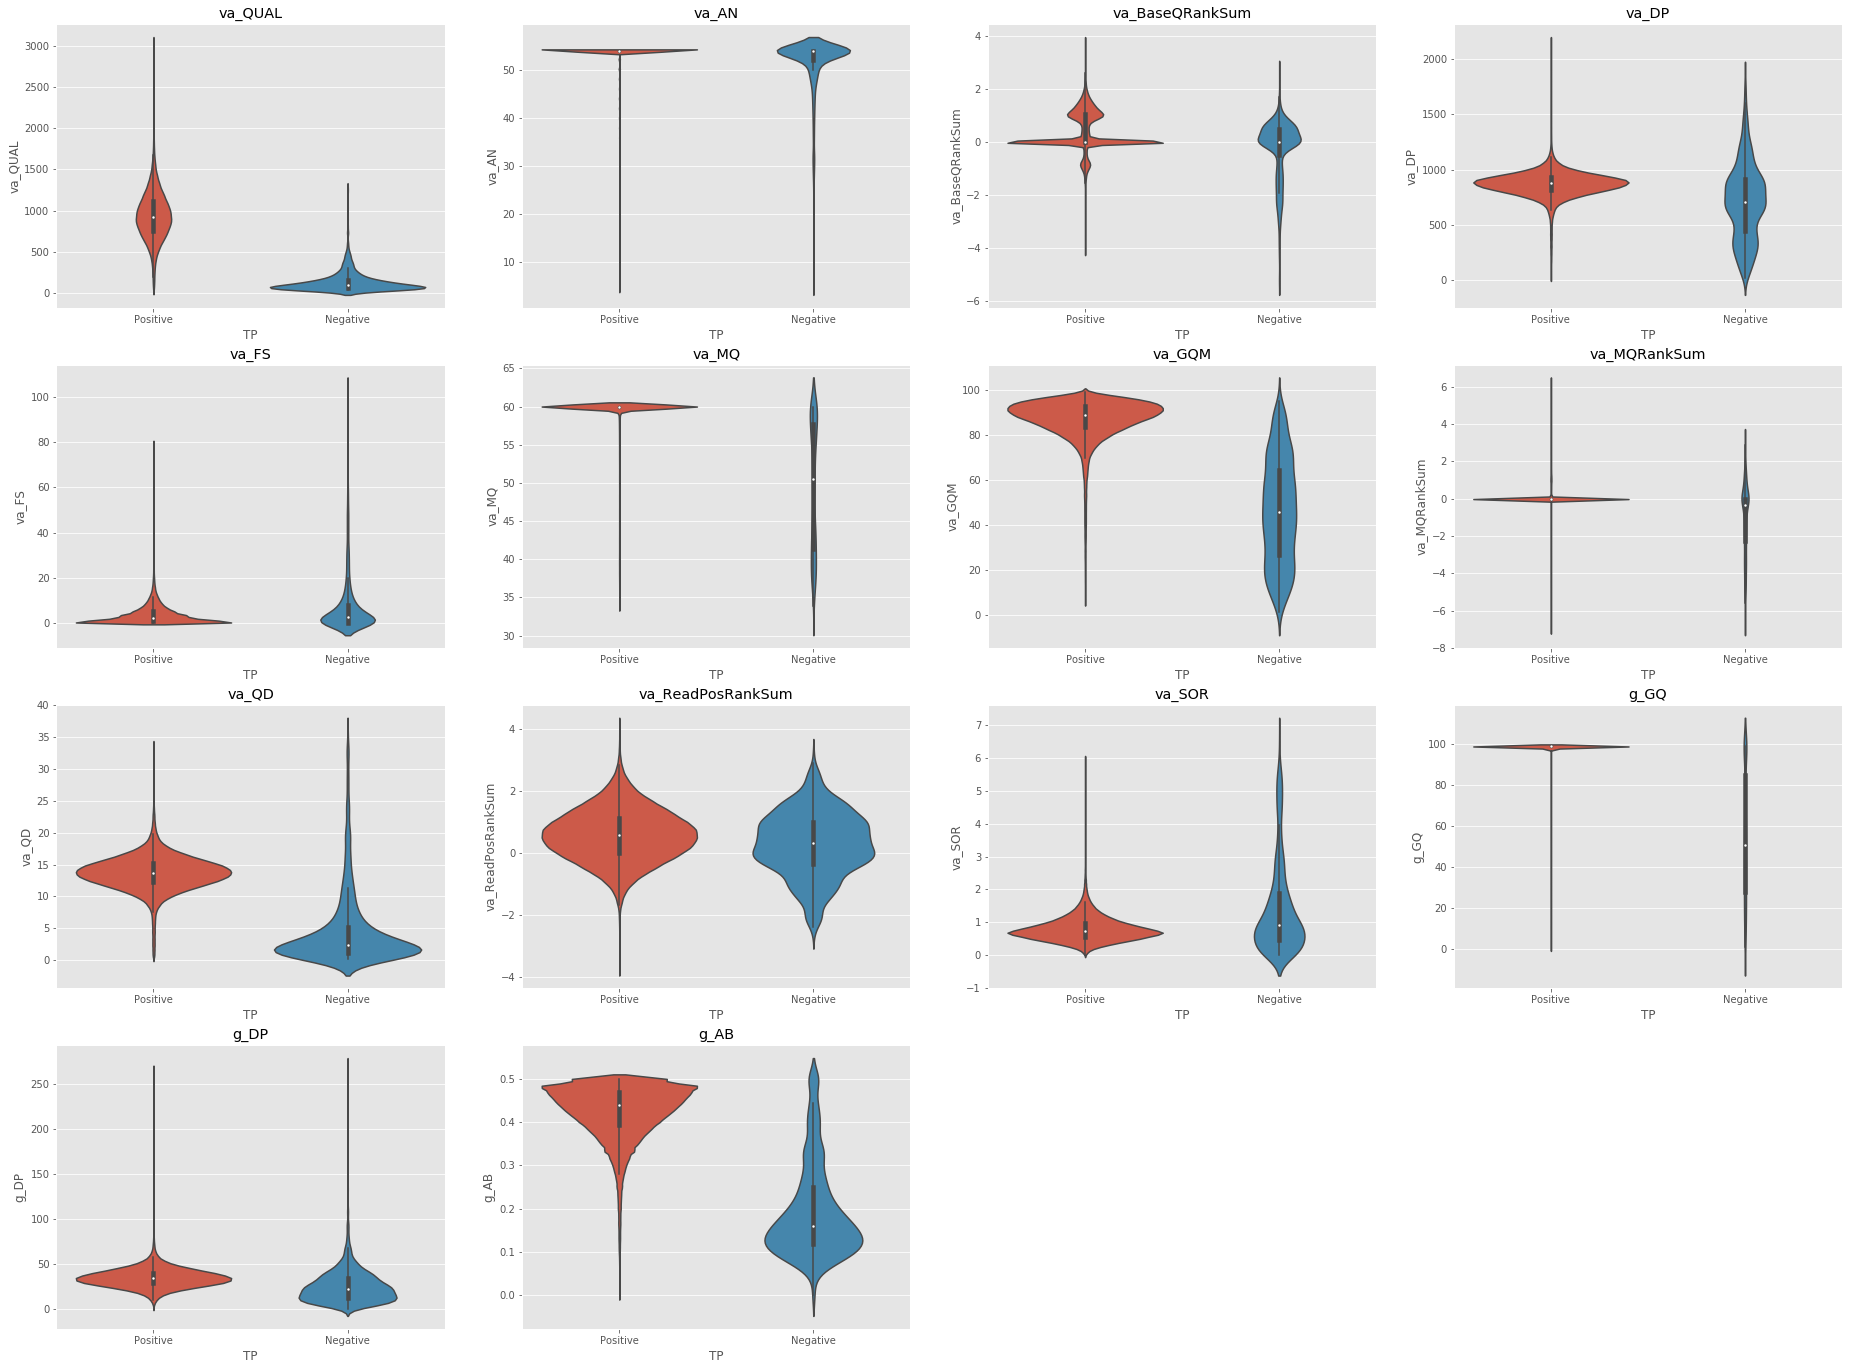

In [127]:
plt.figure(figsize=[32,24])

for k,l in enumerate(criteria, 1):
    plt.subplot(4,4,k)
    sns.violinplot('TP',l, data= df_SNP)
    plt.title(l) 

plt.savefig("../../Figures/plot_PN_SNP.png", )

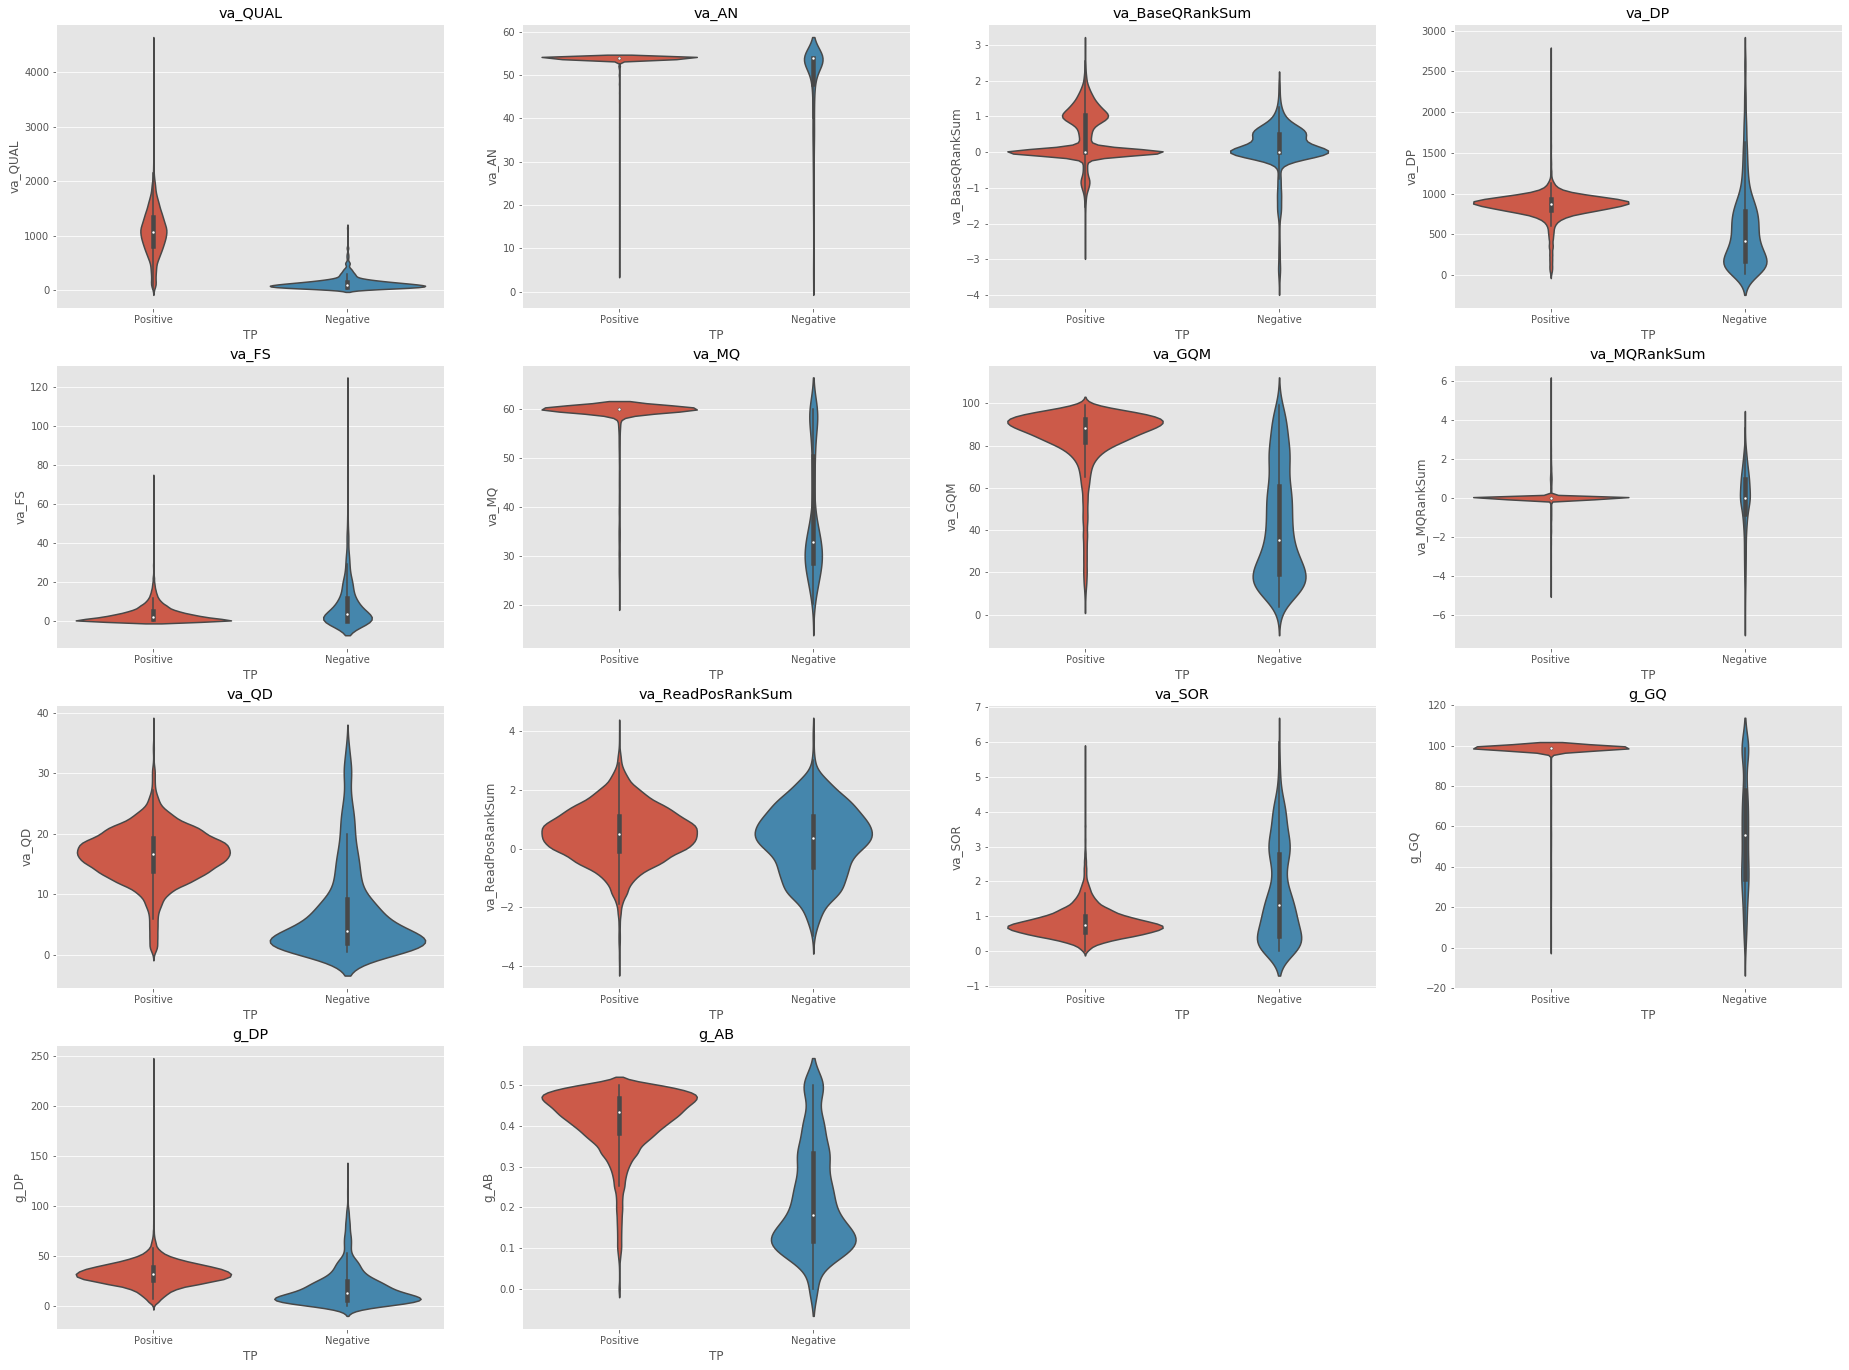

In [128]:
plt.figure(figsize=[32,24])

for k,l in enumerate(criteria, 1):
    plt.subplot(4,4,k)
    sns.violinplot('TP',l, data= df_Indel)
    plt.title(l) 

plt.savefig("../../Figures/plot_PN_Indel.png", )

---

#### 8. (Positive, Negative set) ROCube


In [33]:
import os 
os.chdir('/Users/lizzychoi/rett_syndrome/scripts/rocube')

In [124]:
!python rocube.py -i ../../outputs/ROCube_trainMat_rett_SNP.tsv -p yes

[Progress] Loaded an input data.
[Progress] Plot the distribution of quality metrics
/Users/lizzychoi/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/lizzychoi/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
[Progress] Plotting is done
[Progress] DataFrame is ready for analysis.
[Progress] Start ROC for the round 1
[Progress] ROC Round 1 training sets: Positives 116341 , Negatives 894
[Progress] Achieved specificity 0.84787 and sensitivity 0.99004 from the quality metric va_QUAL (threshold: 214.9)
[Progress] Achieved specificity 0.20582 and sensitivity 0.

In [125]:
!python rocube.py -i ../../outputs/ROCube_trainMat_rett_Indel.tsv -p yes

[Progress] Loaded an input data.
[Progress] Plot the distribution of quality metrics
/Users/lizzychoi/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/lizzychoi/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
[Progress] Plotting is done
[Progress] DataFrame is ready for analysis.
[Progress] Start ROC for the round 1
[Progress] ROC Round 1 training sets: Positives 10874 , Negatives 457
[Progress] Achieved specificity 0.26477 and sensitivity 0.99522 from the quality metric va_QUAL (threshold: 65.78)
[Progress] Achieved specificity 0.07877 and sensitivity 0.9

[Progress] Achieved specificity 0.04186 and sensitivity 0.99543 from the quality metric va_BaseQRankSum (threshold: -1.501)
[Progress] Achieved specificity 0.04186 and sensitivity 0.99627 from the quality metric va_FS (threshold: -23.033)
[Progress] Achieved specificity 0.19535 and sensitivity 0.99515 from the quality metric va_MQ (threshold: 27.41)
[Progress] Achieved specificity 0.13953 and sensitivity 0.99524 from the quality metric va_MQRankSum (threshold: -2.43)
[Progress] Achieved specificity 0.24651 and sensitivity 0.99515 from the quality metric va_QD (threshold: 2.33)
[Progress] Achieved specificity 0.11163 and sensitivity 0.99533 from the quality metric va_GQM (threshold: 18.0)
[Progress] Achieved specificity 0.14419 and sensitivity 0.99505 from the quality metric g_GQ (threshold: 30.0)
[Progress] Achieved specificity 0.16279 and sensitivity 0.99505 from the quality metric g_AB (threshold: 0.11)
[Progress] Achieved specificity 0.07907 and sensitivity 0.99748 from the quality 

[Progress] Achieved specificity 0.1 and sensitivity 0.99213 from the quality metric va_BaseQRankSum (threshold: -1.26)
[Progress] Achieved specificity 0.03333 and sensitivity 0.99933 from the quality metric va_FS (threshold: -32.343)
[Progress] Achieved specificity 0.21667 and sensitivity 0.99079 from the quality metric va_MQRankSum (threshold: -1.674)
[Progress] Achieved specificity 0.28333 and sensitivity 0.99079 from the quality metric g_GQ (threshold: 69.0)
[Progress] Achieved specificity 0.21667 and sensitivity 0.9929 from the quality metric g_DP (threshold: 8.0)
            metric     cut     sens     spec
3             g_GQ  69.000  0.99079  0.28333
2     va_MQRankSum  -1.674  0.99079  0.21667
4             g_DP   8.000  0.99290  0.21667
0  va_BaseQRankSum  -1.260  0.99213  0.10000
1            va_FS -32.343  0.99933  0.03333
[Progress] Completed ROC for the round 9. The most probable metric from this round is g_GQ
[Progress] Round 9: sensitivity 0.94988 , specificity 0.89278
--

---

##### discussion
(2019.11.29)
- ~(info에)`va_HaplotypeScore`, `va_MQ0`, `va_GQM`이 없어서 0으로 둠~

---
(2019.12.5)
- variant filtering 추가 ((1)`Filter == pass`, (2)gnomAD에 AF 정보 없는 variant) : ~*생각보다 여전히 training set의 크기가 크다*~
- 그래프 추가(positive set vs. negative set)
- **rocube** : ~기준(`'va_QUAL','va_AN','va_DP','va_MQ','va_QD','g_AB','g_DP'`)만 사용해서 돌려본 결과~



---

(2019. 12. 9)


- gnomAD AC==0만 포함 : 'VEP annotation 결과사용'한 경우와 'gnomAD VCF을 사용'한 경우 차이가 난다. => *우선은 'VEP annotation'결과만 사용*
    - **branch** 새로 만들어서 'gnomAD VCF을 사용'한 경우해보자
- 그래프 기준 추가 : **g_GQ**~(variant qc이후 gq mean 사용)~, **g_DP**(그래프 그릴때 계산), **g_AB**(그래프 그릴때 계산)

---

(2019. 12. 13)

- autosomal contigs만 남김(즉, X, Y, and MT 모두 제외)
- (training set)`va_HaplotypeScore`, `va_MQ0` 제외, **`va_GQM`**은 `variant_qc.gq_stats.mean`으로(2019.11.29 수정)
- rocube
    - `va_ExcessHet`, `va_InbreedingCoeff`, `va_VQSLOD`는 왜 안 쓰는지
    - Indel에서는 `va_ReadPosRankSum`제외하고 실행



(2019.12.17) 
- False positive 기준 수정 : 하나는 **무조건 자손**에게서 발견되어야한다.(수정 완료)--> negative 수가 많이 줄음

(2019.12.23)
- False positive 기준 수정: 다른 하나는 **부모**에게서 발견되어야한다. --> negative 수 더 줄음